#### Data Loading

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    AutoTokenizer,
    get_scheduler,
)
from pycocotools.coco import COCO
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import os
import math
from collections import Counter

print("All necessary libraries imported.")


data_root = "C:\Datasets\COCO" 

# Define paths to the specific files and folders we need
train_image_dir = os.path.join(data_root, 'train2017')
val_image_dir = os.path.join(data_root, 'val2017')
annotations_dir = os.path.join(data_root, 'annotations_trainval2017\\annotations')
train_annotation_file = os.path.join(annotations_dir, 'captions_train2017.json')
val_annotation_file = os.path.join(annotations_dir, 'captions_val2017.json')

print("Paths configured.")

print(f"Loading annotations from: {train_annotation_file}")
coco = COCO(train_annotation_file)
print("Annotations loaded successfully.")

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Karthick\AppData\Local\Temp\ipykernel_14976\203269374.py:21: SyntaxWarning: invalid escape sequence '\D'
  data_root = "C:\Datasets\COCO"


All necessary libraries imported.
Paths configured.
Loading annotations from: C:\Datasets\COCO\annotations_trainval2017\annotations\captions_train2017.json
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
Annotations loaded successfully.


In [12]:
# Get all annotation IDs, then get the annotations themselves
all_ann_ids = list(coco.anns.keys())
all_annotations = coco.loadAnns(all_ann_ids)

# Calculate the length (in words) of each caption
caption_lengths = [len(ann['caption'].split()) for ann in all_annotations]

# Use pandas for easy statistics
series_lengths = pd.Series(caption_lengths)
print("\n--- Caption Length Statistics ---")
print(series_lengths.describe(percentiles=[.25, .5, .75, .90, .95, .99]))

# Plot a histogram to visualize the distribution
plt.figure(figsize=(12, 6))
series_lengths.hist(bins=40, range=(0, 40))
plt.title('Distribution of Caption Lengths in COCO Train Set')
plt.xlabel('Number of Words')
plt.ylabel('Frequency (Count)')
plt.grid(axis='y', alpha=0.75)
plt.show()

NameError: name 'pd' is not defined

In [ ]:
# Create a word counter
word_counts = Counter()

# Iterate through all captions and count words
for ann in all_annotations:
    # Basic cleaning: lowercase and split
    words = ann['caption'].lower().split()
    word_counts.update(words)

print(f"\n--- Vocabulary Analysis ---")
print(f"Total unique words: {len(word_counts)}")
print("25 most common words:")
print(word_counts.most_common(25))


--- Vocabulary Analysis ---
Total unique words: 44042
25 most common words:
[('a', 978597), ('on', 213970), ('of', 204037), ('the', 197716), ('in', 183765), ('with', 154769), ('and', 140721), ('is', 98128), ('man', 72282), ('to', 68112), ('sitting', 52805), ('an', 49870), ('two', 48298), ('at', 42692), ('standing', 42312), ('are', 41063), ('people', 40411), ('next', 37198), ('white', 35663), ('woman', 33473), ('that', 27927), ('holding', 27918), ('some', 24316), ('large', 24263), ('person', 24125)]


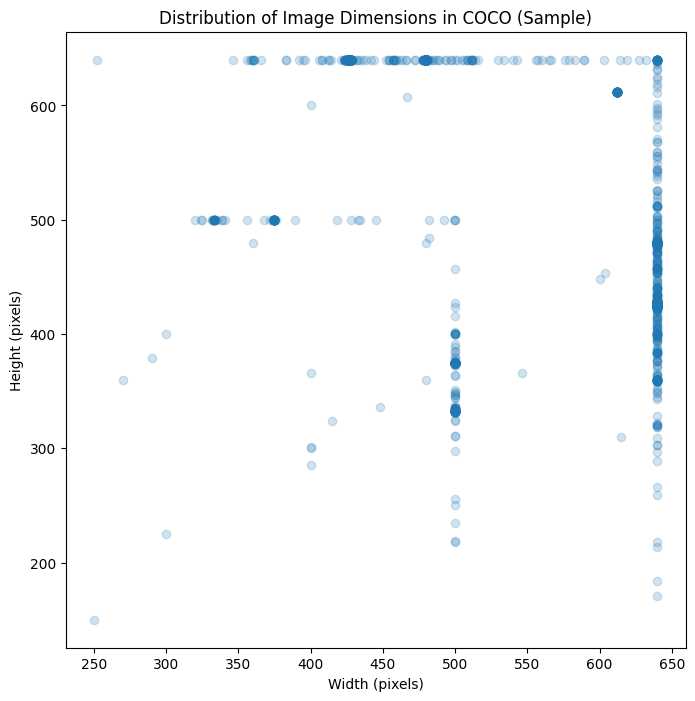

In [ ]:
import random

# Get all image IDs
img_ids = coco.getImgIds()
sample_img_ids = random.sample(img_ids, 2000) # Analyze a random sample of 2000 images
images_info = coco.loadImgs(sample_img_ids)

# Extract widths and heights
widths = [img['width'] for img in images_info]
heights = [img['height'] for img in images_info]

# Plot a scatter plot of image dimensions
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, alpha=0.2)
plt.title('Distribution of Image Dimensions in COCO (Sample)')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

#### Data Processing

In [13]:

class CocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, processor, tokenizer, max_length=64):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.anns.keys())
        
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # 1. Get the annotation details
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        
        # 2. Get image file path
        path = self.coco.loadImgs(img_id)[0]['file_name']
        image_path = os.path.join(self.root_dir, path)
        
        # 3. Load and process the image
        try:
            image = Image.open(image_path).convert('RGB')
            pixel_values = self.processor(image, return_tensors="pt").pixel_values
        except (FileNotFoundError, OSError):
            print(f"Warning: Image not found or corrupt, skipping: {image_path}")
            # On error, just grab the next item
            return self.__getitem__((idx + 1) % len(self))

        # 4. Tokenize the caption (this will be our 'labels')
        labels = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids

        return {
            "pixel_values": pixel_values.squeeze(0),
            "labels": labels.squeeze(0),
            "original_caption": caption,
        }

print("CocoDataset class defined.")

CocoDataset class defined.


In [14]:

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token for GPT-2
# This is a standard practice for open-ended generation tasks.
tokenizer.pad_token = tokenizer.eos_token

# Create the training dataset
train_dataset = CocoDataset(
    root_dir=train_image_dir,
    annotation_file=train_annotation_file,
    processor=image_processor,
    tokenizer=tokenizer
)

# Create the validation dataset
val_dataset = CocoDataset(
    root_dir=val_image_dir,
    annotation_file=val_annotation_file,
    processor=image_processor,
    tokenizer=tokenizer
)

print(f"Training dataset has {len(train_dataset)} samples.")
print(f"Validation dataset has {len(val_dataset)} samples.")

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Training dataset has 591753 samples.
Validation dataset has 25014 samples.


In [15]:

batch_size = 16 

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"DataLoaders created with batch size {batch_size}.")

DataLoaders created with batch size 16.


In [16]:
encoder_model_name = "google/vit-base-patch16-224-in21k"

decoder_model_name = "gpt2"

print(f"Encoder will be: {encoder_model_name}")
print(f"Decoder will be: {decoder_model_name}")

Encoder will be: google/vit-base-patch16-224-in21k
Decoder will be: gpt2


In [17]:
# Instantiate the VisionEncoderDecoderModel
# This is the core of our model. The from_encoder_decoder_pretrained method
# downloads both pre-trained models and wires them together with a
# cross-attention mechanism, allowing the decoder to "attend to" the
# image features from the encoder.

# This step will download several gigabytes of model weights on its first run.
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model_name, decoder_model_name
)

print("VisionEncoderDecoderModel instantiated successfully.")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

VisionEncoderDecoderModel instantiated successfully.


In [18]:
# --- Link Tokenizer to Model ---
# The model needs to know which token IDs correspond to special tokens.
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# --- Set Generation Parameters ---
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = tokenizer.eos_token_id
model.config.max_length = 64  # Corresponds to max_length in our dataloader
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print("Model configuration updated for generation.")

Model configuration updated for generation.


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Moving model to device: {device}")
model.to(device)

param_device = next(model.parameters()).device
print(f"Model is now on device: {param_device}")

print("Model architecture and configuration complete.")
print(model)

Moving model to device: cuda
Model is now on device: cuda:0
Model architecture and configuration complete.
VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): Vi

In [20]:
def get_ngrams(segment, max_n):
    """Calculates all n-grams up to max_n for a segment."""
    ngram_counts = Counter()
    for n in range(1, max_n + 1):
        for i in range(len(segment) - n + 1):
            ngram = tuple(segment[i:i+n])
            ngram_counts[ngram] += 1
    return ngram_counts

def compute_bleu(reference, candidate, max_n=4):
    """
    Computes the BLEU score for a single candidate sentence against a single reference.
    
    Args:
        reference (str): The ground truth sentence.
        candidate (str): The model-generated sentence.
        max_n (int): The maximum n-gram to consider (e.g., 4 for BLEU-4).
    
    Returns:
        float: The BLEU score.
    """
    # Tokenize sentences
    ref_tokens = reference.lower().split()
    cand_tokens = candidate.lower().split()

    # Brevity Penalty (BP)
    # Penalizes candidates that are shorter than their references.
    ref_len = len(ref_tokens)
    cand_len = len(cand_tokens)
    if cand_len == 0:
        return 0.0
    
    brevity_penalty = 1.0
    if cand_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / cand_len)

    # Get n-gram counts
    ref_ngrams = get_ngrams(ref_tokens, max_n)
    cand_ngrams = get_ngrams(cand_tokens, max_n)

    # Calculate clipped precision for each n-gram order
    clipped_precision_score = 0.0
    for n in range(1, max_n + 1):
        # Numerator: sum of clipped counts
        numerator = 0
        # Denominator: total count of n-grams in the candidate
        denominator = max(1, len(cand_tokens) - n + 1)
        
        # Get all n-grams of order n from the candidate
        cand_ngrams_n = {k: v for k, v in cand_ngrams.items() if len(k) == n}
        
        for ngram, count in cand_ngrams_n.items():
            # Clip the count by the max count in the reference
            ref_count = ref_ngrams.get(ngram, 0)
            clipped_count = min(count, ref_count)
            numerator += clipped_count
        
        precision = numerator / denominator
        
        # Use log precision to avoid numerical underflow, add smoothing
        if precision > 0:
            clipped_precision_score += (1/max_n) * math.log(precision)

    # Final BLEU score
    bleu_score = brevity_penalty * math.exp(clipped_precision_score)
    
    return bleu_score

print("Custom BLEU score function defined.")


Custom BLEU score function defined.


In [21]:


# --- Paths ---
# IMPORTANT: UPDATE THIS PATH
data_root = "C:/path/to/your/downloaded/folder/"
output_dir = "vit-gpt2-coco-finetuned-from-scratch"
os.makedirs(output_dir, exist_ok=True)

# --- Model & Tokenizer ---
encoder_model_name = "google/vit-base-patch16-224-in21k"
decoder_model_name = "gpt2"

# --- Training Hyperparameters ---
num_epochs = 3
train_batch_size = 16 # Adjust based on your GPU memory
val_batch_size = 16
learning_rate = 5e-5

# --- Data Processing ---
max_text_length = 64

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Configuration loaded. Using device: {device}")

Configuration loaded. Using device: cuda


In [22]:
# Cell 7: Optimizer, Scheduler, and Final Model Setup
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

print("Optimizer and Scheduler ready.")

Optimizer and Scheduler ready.


In [ ]:
# Cell 8: The Main Training and Validation Loop
best_bleu = 0.0

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    print(f"\n--- Starting Epoch {epoch + 1}/{num_epochs} ---")
    train_progress_bar = tqdm(train_dataloader, desc="Training")
    
    for batch in train_progress_bar:
        pixel_values = batch.pop("pixel_values").to(device)
        labels = batch.pop("labels").to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        train_progress_bar.set_postfix({"loss": loss.item()})

    # --- Validation Phase ---
    model.eval()
    print(f"--- Running Validation for Epoch {epoch + 1} ---")
    total_bleu_score = 0.0
    val_progress_bar = tqdm(val_dataloader, desc="Validation")
    
    for batch in val_progress_bar:
        pixel_values = batch.pop("pixel_values").to(device)
        original_captions = batch.pop("original_caption") # This is a list of strings
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values, max_new_tokens=max_text_length)
        
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Calculate BLEU for each item in the batch
        for i in range(len(decoded_preds)):
            candidate = decoded_preds[i]
            reference = original_captions[i]
            total_bleu_score += compute_bleu(reference, candidate)
    
    avg_bleu = total_bleu_score / len(val_dataset)
    
    print(f"--- Epoch {epoch + 1} Validation Results ---")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    
    # --- Save the Best Model ---
    if avg_bleu > best_bleu:
        best_bleu = avg_bleu
        print(f"New best BLEU score! Saving model to {output_dir}")
        torch.save(model.state_dict(), os.path.join(output_dir, "best_model.pth"))
        tokenizer.save_pretrained(output_dir)
        image_processor.save_pretrained(output_dir)

print("\n--- Fine-Tuning Complete ---")
print(f"Best Average BLEU score achieved: {best_bleu:.4f}")


--- Starting Epoch 1/3 ---


Training:   0%|          | 0/36985 [00:00<?, ?it/s]